In [33]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/christinedekock/wp_internship/collaboration/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import pandas as pd
from dateutil import parser
import datetime
import numpy as np
import json
import matplotlib.pylab as plt

from utils import get_edits_pre_tag

In [35]:
revisions = pd.read_csv('/Users/christinedekock/wp_internship/data/formatted_data/autobiography.csv')

/Users/christinedekock/opt/anaconda3/envs/ml_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
revisions['event_timestamp'] = pd.to_datetime(revisions['event_timestamp'])

In [200]:
pre_edit = revisions

In [103]:
# group by page, namespace = 0
TIMEFRAME_DAYS = 7

def article_age_years(page_revisions):
    diff = page_revisions.event_timestamp.max() - page_revisions.event_timestamp.min()
    diff = diff // datetime.timedelta(days=365.2425)
    return diff

def curr_size(page_revisions):
    return page_revisions.iloc[-1].revision_text_bytes

def frac_minor_edits(page_revisions):
    return page_revisions.revision_minor_edit.mean()

def last_edit_size(page_revisions):
    edits = page_revisions[-2:].revision_text_bytes.values
    return edits[0]/edits[1]

def num_revisions(page_revisions):
    return len(page_revisions)

def num_editors(page_revisions):
    return page_revisions.event_user_id.nunique()
               
def frac_recent_revisions(page_revisions, days=TIMEFRAME_DAYS):
    start_time = page_revisions.event_timestamp.max() - datetime.timedelta(days=days)
    recent = page_revisions.query('event_timestamp > @start_time')    
    return len(recent) / len(page_revisions)


In [185]:
pages = pre_edit.groupby('page_id')
pre_edit['time_to_respond'] = pages['event_timestamp'].diff().dt.days.abs().fillna(0)
pre_edit['time_responded_to'] = pages['event_timestamp'].diff(-1).dt.days.abs().fillna(0)
pre_edit['revision_text_bytes'] = pre_edit['revision_text_bytes'].apply(lambda x: x if type(x)==int else 0)
pre_edit['edit_size'] = pages['revision_text_bytes'].diff().fillna(pre_edit.revision_text_bytes)
pre_edit['next_edit_size'] = pages['revision_text_bytes'].diff()[1:].tolist() + [0]
pre_edit['revision_is_identity_revert'] = pre_edit.revision_id.isin(pre_edit.revision_first_identity_reverting_revision_id)

In [40]:
# group by page and user

def num_revisions(user_revisions):
    return len(user_revisions)

def frac_edits_reverted(user_revisions):
    return user_revisions.revision_is_identity_reverted.mean()

def frac_reverted_others(user_revisions):
    return user_revisions.revision_is_identity_revert.mean()

def mean_revision_size(user_revisions):
    return user_revisions.edit_size.mean()

def size_of_edits_after(user_revisions):
    return user_revisions.next_edit_size.mean()
    
def time_to_respond(user_revisions):
    return user_revisions.time_to_respond.mean()
    
def time_reponded_to(user_revisions):
    return user_revisions.time_responded_to.mean()

## these are all just column means; easier to just do them at once

def user_revision_feat(user_revisions):
    return user_revisions[['revision_is_identity_reverted','revision_is_identity_revert','edit_size',
                          'next_edit_size','time_to_respond','time_responded_to']].mean()

In [41]:
# Talk page

In [201]:
talk_page_revisions = pre_edit.query('page_namespace==1')

In [202]:
article_revisions = pre_edit[(pre_edit.page_namespace==0) & 
                              (pre_edit.page_title.isin(talk_page_revisions.page_title))]

In [203]:
ratios = (article_revisions.groupby('page_title')['event_timestamp'].count() / 
          talk_page_revisions.groupby('page_title')['event_timestamp'].count()).dropna()

In [208]:
ratios

page_title
Al_Connelly                          17.571429
Alex_Konanykhin                       2.702703
Amanda_Eliasch                        4.052083
Anthony_Hudson_(football_manager)    15.727273
Detlef_Soost                         11.750000
H._Raja                              21.963415
J._Scott_Armstrong                    2.500000
JJ_Rendón                            35.000000
Jamie_Kaler                           8.750000
Joe_Arpaio                            5.033635
Joe_Bock_(American_football)          6.176471
Michael_J._Jacobs                     9.750000
Scott_Rasmussen                       3.884393
Varo_Venturi                          7.833333
Name: event_timestamp, dtype: float64

In [212]:
def daily_activity(data, start_date):
    data['days_since_start'] = (data['event_timestamp'] - start_date).dt.days
    daily_edit_count = data.groupby('days_since_start').size()
    daily_edit_vol = data.groupby('days_since_start')['edit_size'].apply(lambda x: x.abs().sum())
    df = pd.DataFrame({'daily_edit_count':daily_edit_count,'daily_edit_vol':daily_edit_vol})
    df = df.reindex(np.arange(df.index.min(), df.index.max() + 1)).fillna(0)
    
    return df

def talk_vs_article_activity(talk,article,title,smoothing):
    start_date = article.event_timestamp.min()
    talk_activity = daily_activity(talk,start_date)
    article_activity = daily_activity(article,start_date)
    
    article_activity = article_activity[title].rolling(smoothing).mean().fillna(0)
    talk_activity = talk_activity[title].rolling(smoothing).mean().fillna(0)
    
    template_added = article[article['has_template'].diff()==1].days_since_start.values
    template_removed = article[article['has_template'].diff()==-1].days_since_start.values
    
    return article_activity, talk_activity, template_added, template_removed

def plot_daily_activity(talk, article, title='daily_edit_vol',smoothing=60):
    article_act, talk_act, temp_add, temp_rem = talk_vs_article_activity(talk, article, title, smoothing)
    
    plt.figure(figsize=[12,7])
    plt.scatter(talk_act.index.values,np.log(talk_act.values+1),label='Talk',alpha=0.9)
    plt.plot(talk_act.index.values,np.log(talk_act.values+1))
    plt.scatter(article_act.index.values,np.log(article_act.values+1),label='Article',alpha=0.9)
    plt.plot(article_act.index.values,np.log(article_act.values+1))
    
    for i,t in enumerate(temp_rem):
        plt.axvline(x=t,ls='--',c='b',label='template_removed' if i==0 else None)
        
    for i,t in enumerate(temp_add):
        plt.axvline(x=t,ls='--',c='r',label='template_added' if i==0 else None)
    
    plt.xlabel('Days since start')
    plt.ylabel('Log '+title)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

In [213]:
talk_grouped = talk_page_revisions.groupby('page_title')
article_grouped = article_revisions.groupby('page_title')

/Users/christinedekock/opt/anaconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


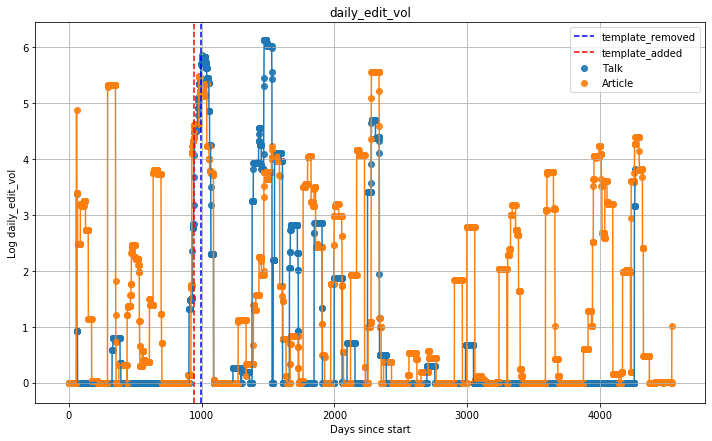

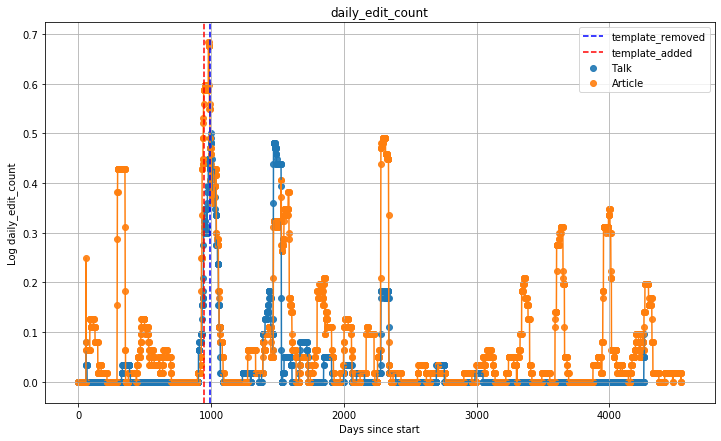

In [214]:
page = 'Alex_Konanykhin'

fig = plot_daily_activity(talk_grouped.get_group(page),
                          article_grouped.get_group(page),
                          'daily_edit_vol',60)

fig = plot_daily_activity(talk_grouped.get_group(page),
                          article_grouped.get_group(page),
                          'daily_edit_count',60)

Al_Connelly


/Users/christinedekock/opt/anaconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


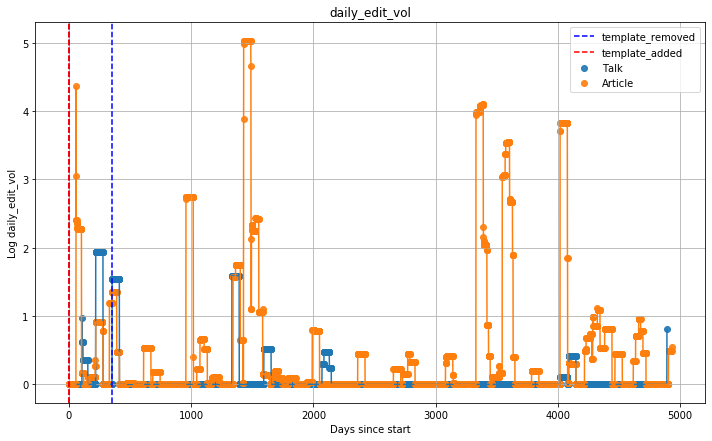

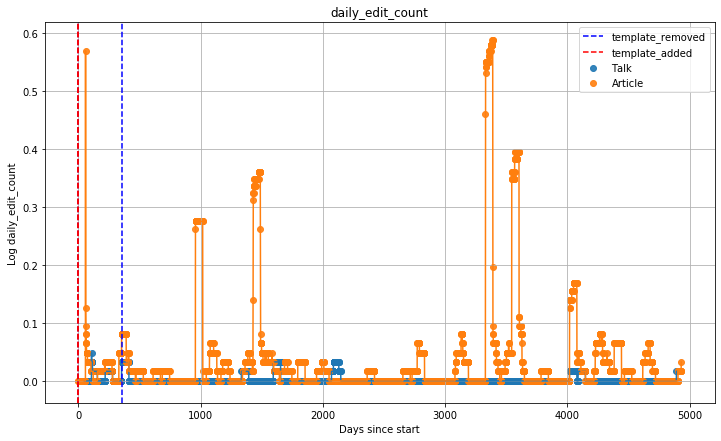

Alex_Konanykhin


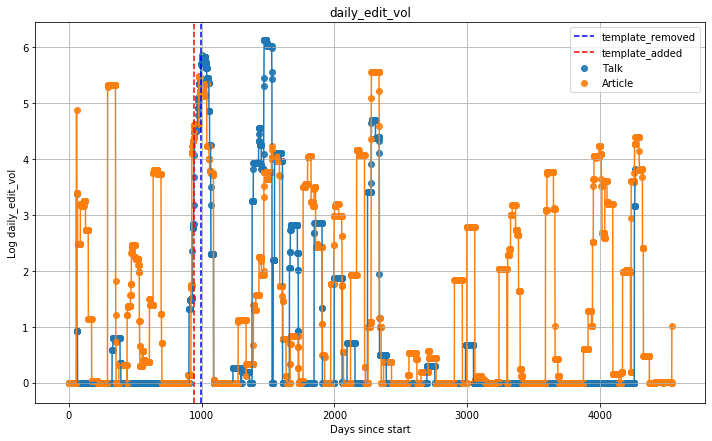

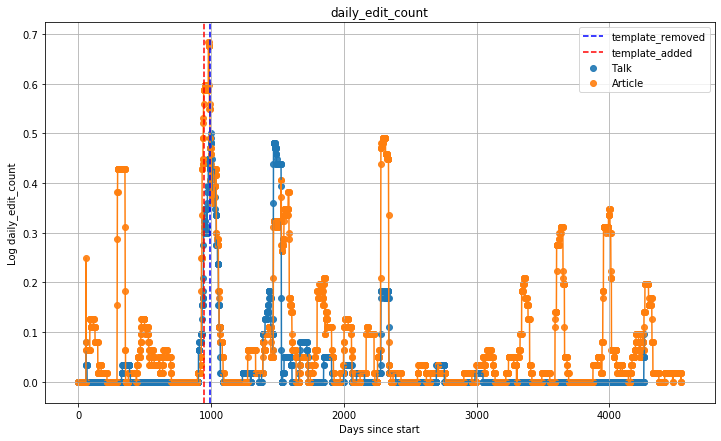

Amanda_Eliasch


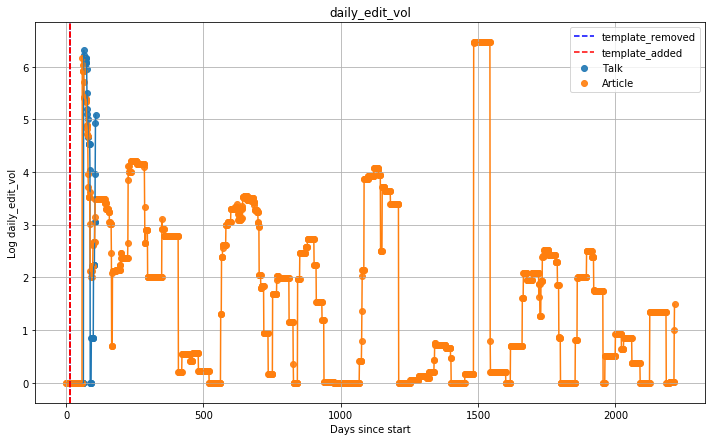

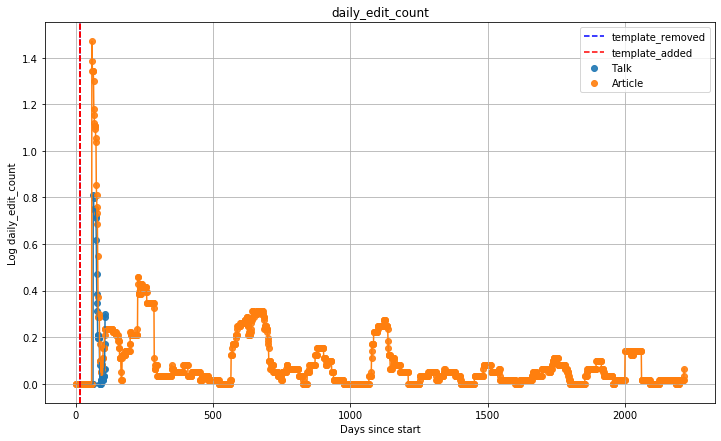

Anthony_Hudson_(football_manager)


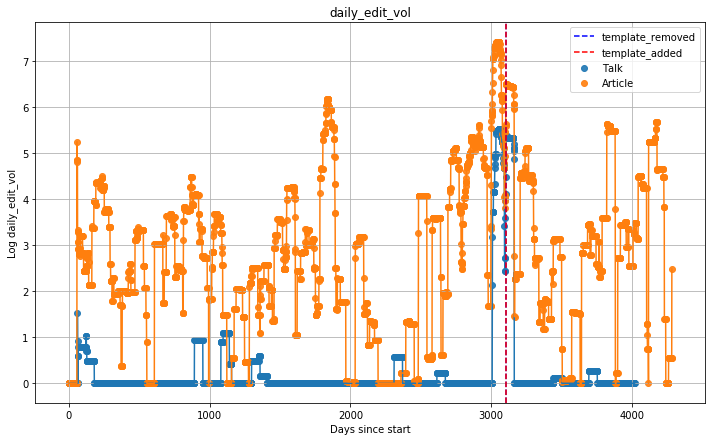

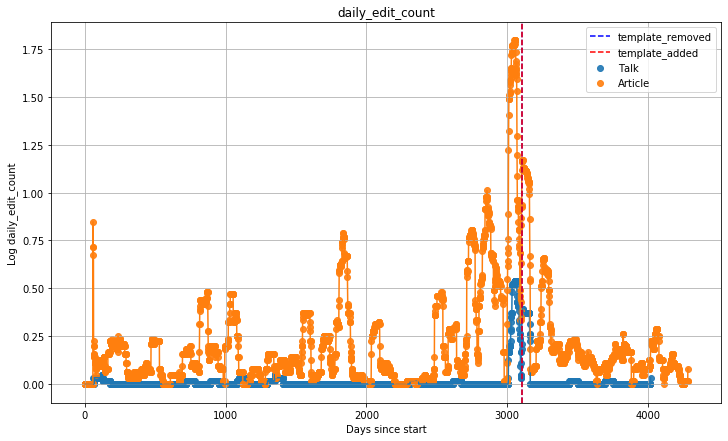

Detlef_Soost


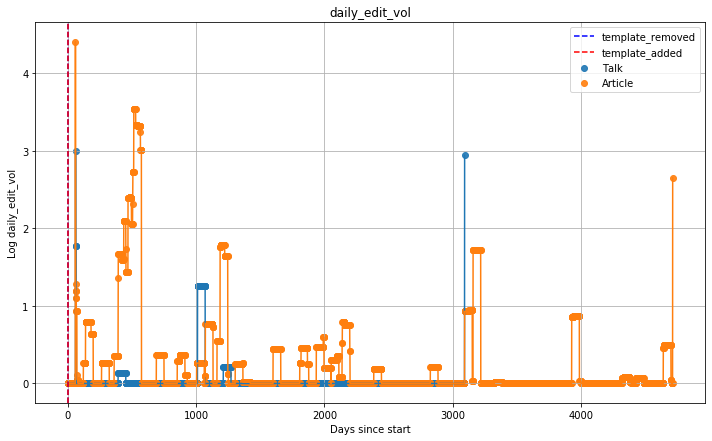

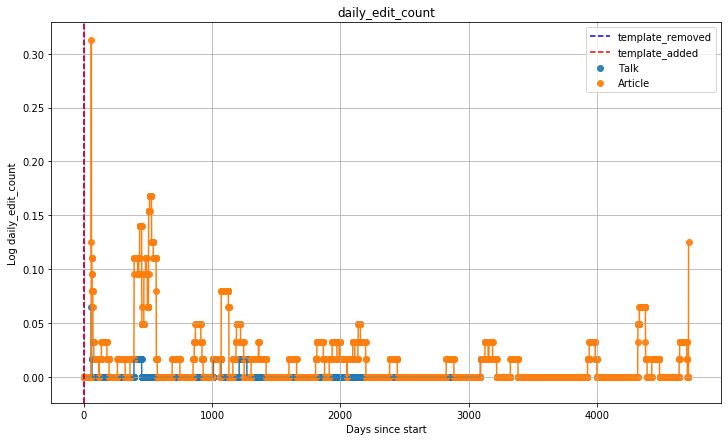

H._Raja


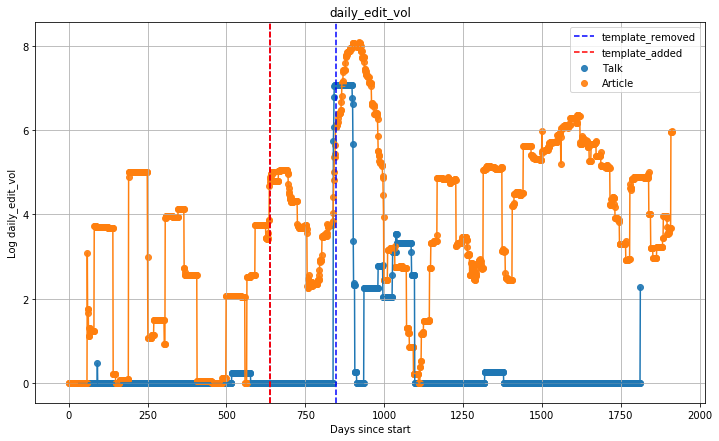

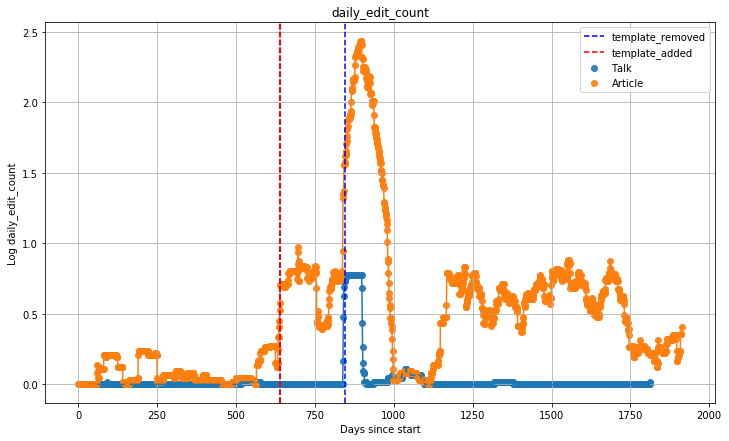

J._Scott_Armstrong


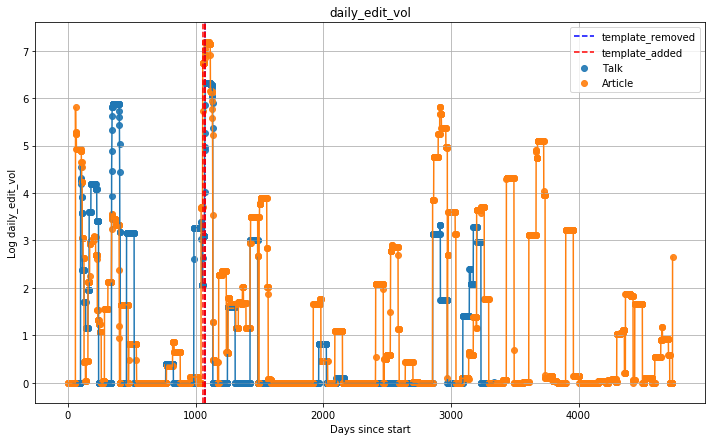

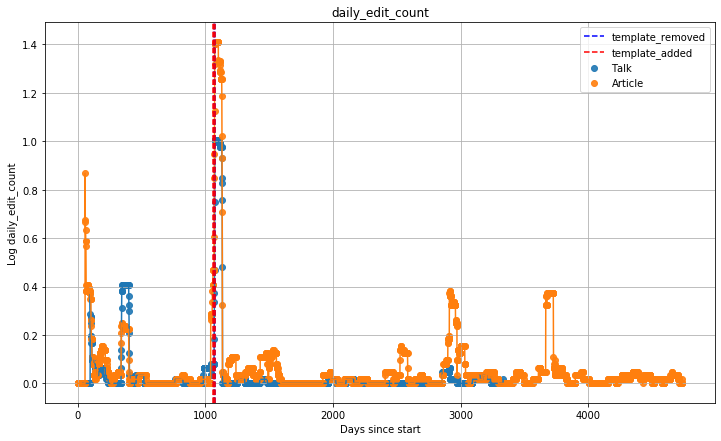

JJ_Rendón


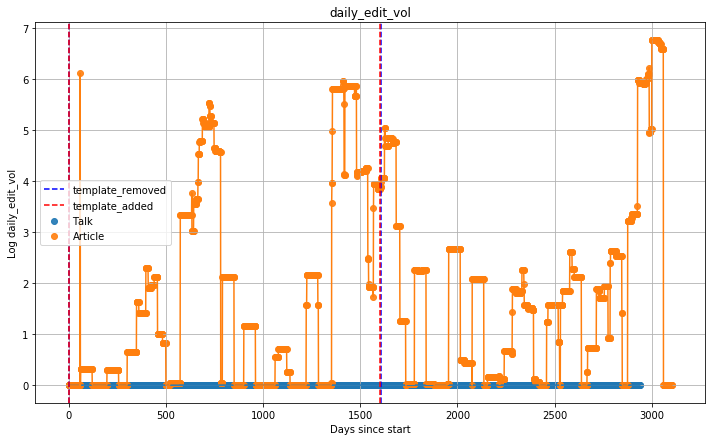

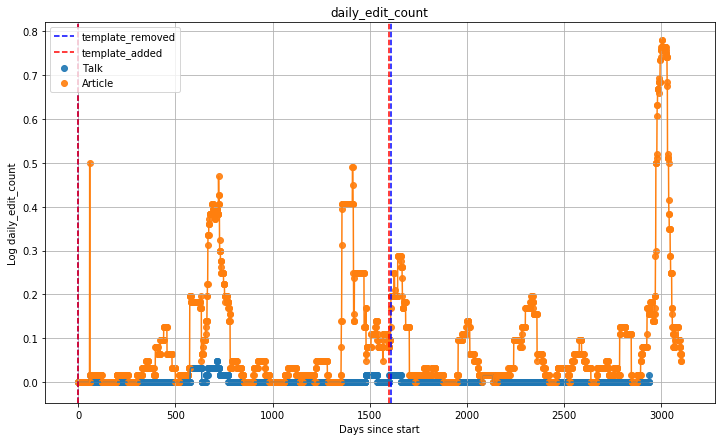

Jamie_Kaler


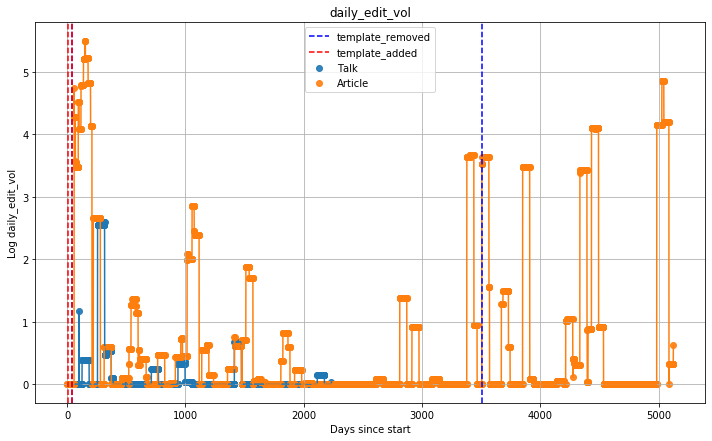

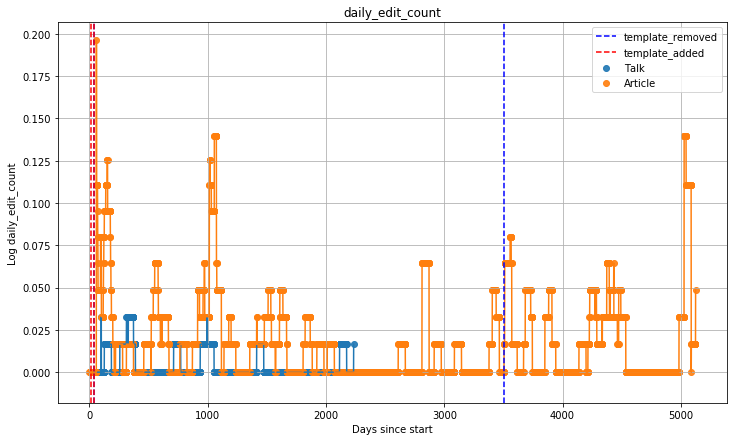

Joe_Arpaio


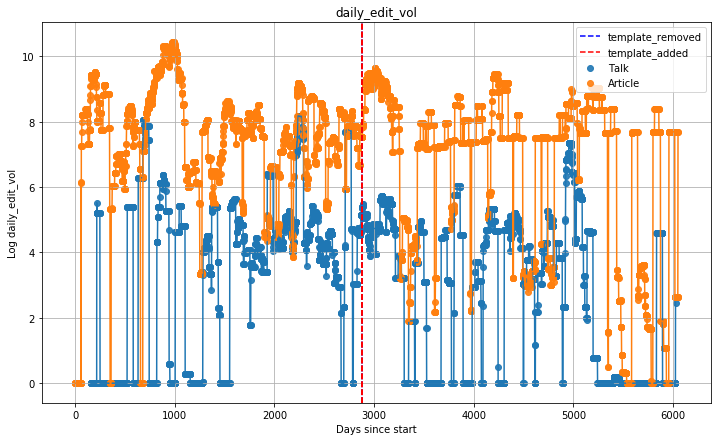

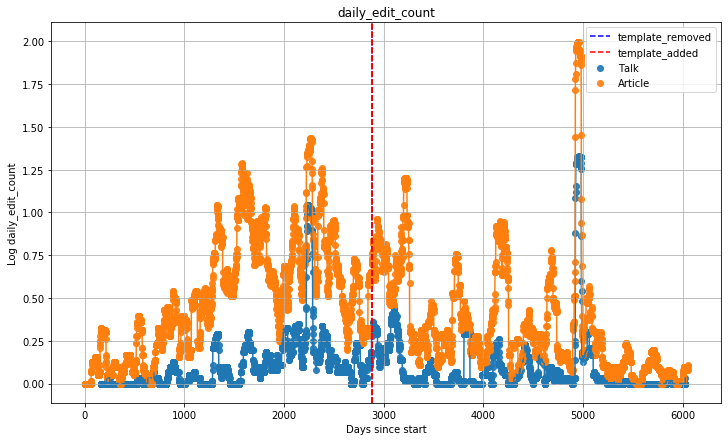

Joe_Bock_(American_football)


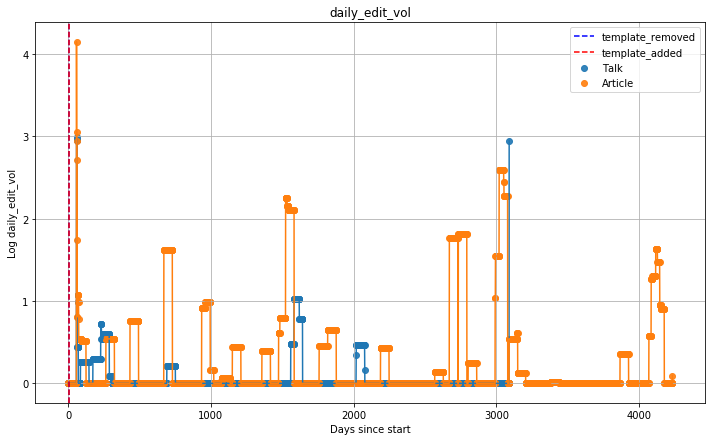

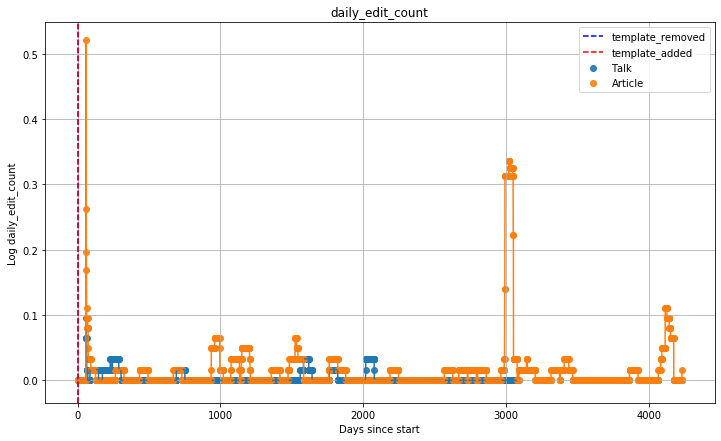

Michael_J._Jacobs


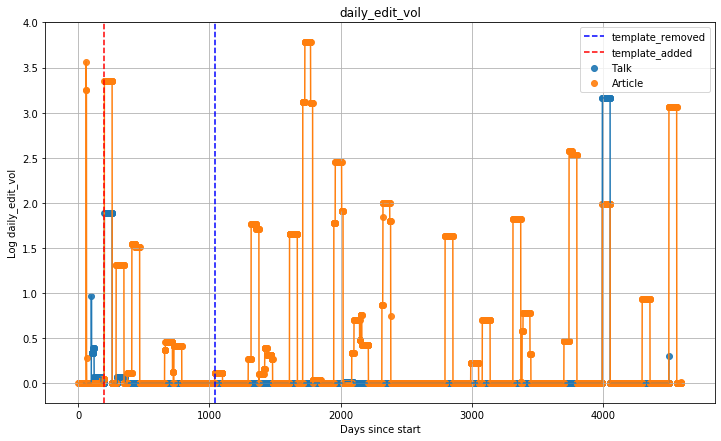

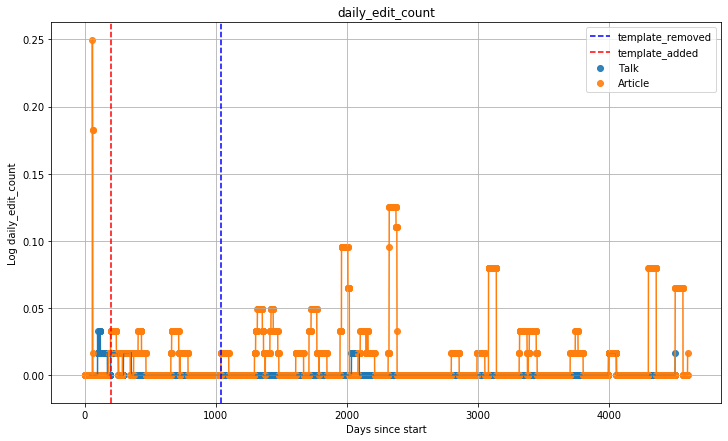

Scott_Rasmussen


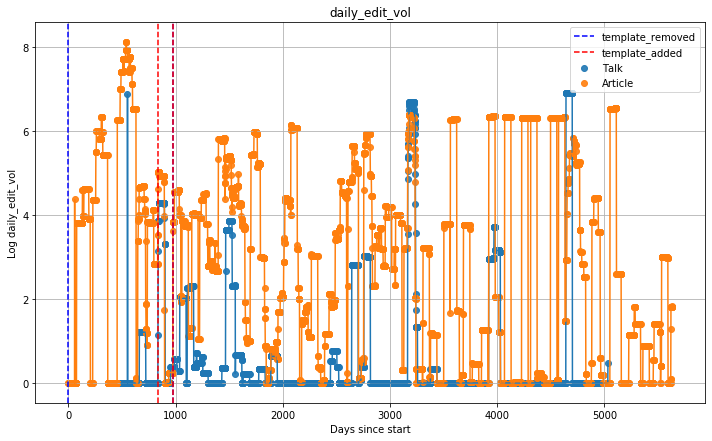

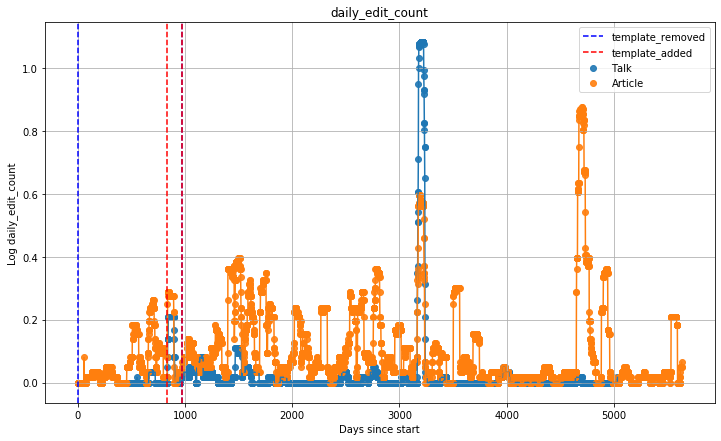

Varo_Venturi


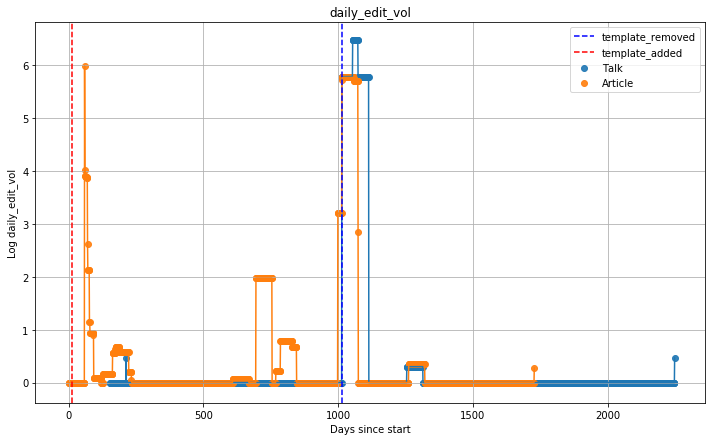

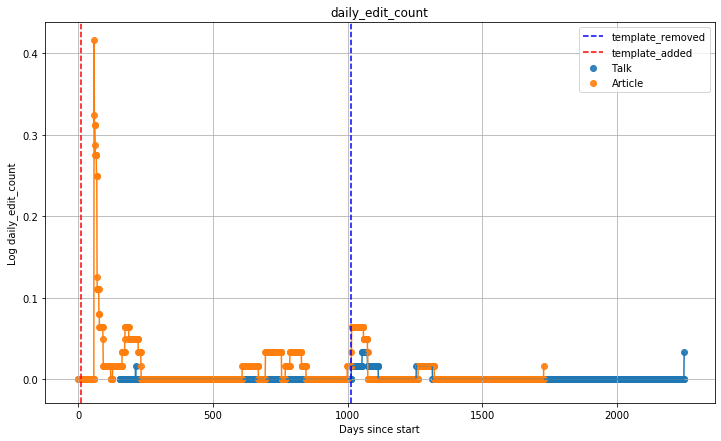

In [215]:
talk_grouped = talk_page_revisions.groupby('page_title')
article_grouped = article_revisions.groupby('page_title')

for page in ratios.index.values:
    print(page)
    fig = plot_daily_activity(talk_grouped.get_group(page),
                              article_grouped.get_group(page),
                              'daily_edit_vol',60)

    fig = plot_daily_activity(talk_grouped.get_group(page),
                              article_grouped.get_group(page),
                              'daily_edit_count',60)

In [216]:
# before template

In [217]:
def get_edits_pre_tag(data):
    ix = data['has_template'].idxmax()
    return data.loc[:ix]

In [218]:
pre_template = pre_edit.groupby('page_id').apply(get_edits_pre_tag)

In [219]:
talk_page_revisions = pre_template.query('page_namespace==1')

In [220]:
article_revisions = pre_template[(pre_template.page_namespace==0) & 
                              (pre_template.page_title.isin(talk_page_revisions.page_title))]

In [221]:
ratios = (article_revisions.groupby('page_title')['event_timestamp'].count() / 
          talk_page_revisions.groupby('page_title')['event_timestamp'].count()).dropna()

Al_Connelly


/Users/christinedekock/opt/anaconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


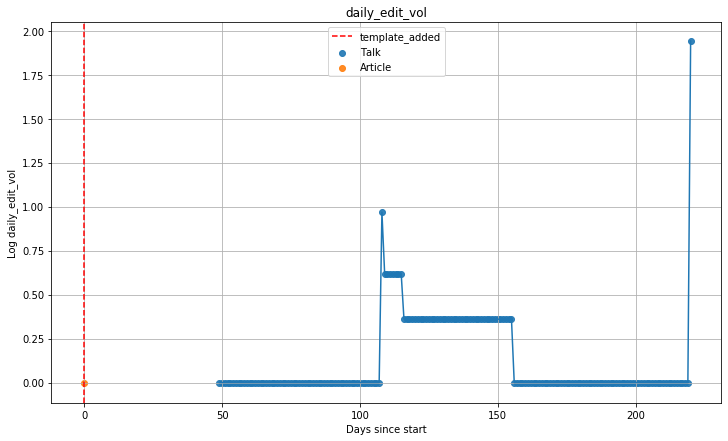

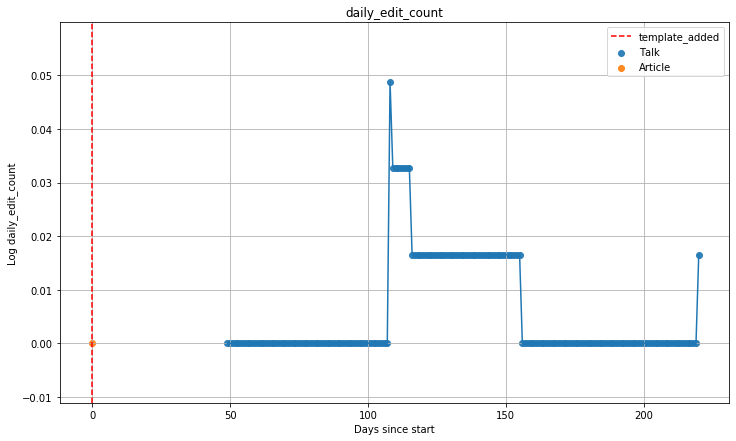

Alex_Konanykhin


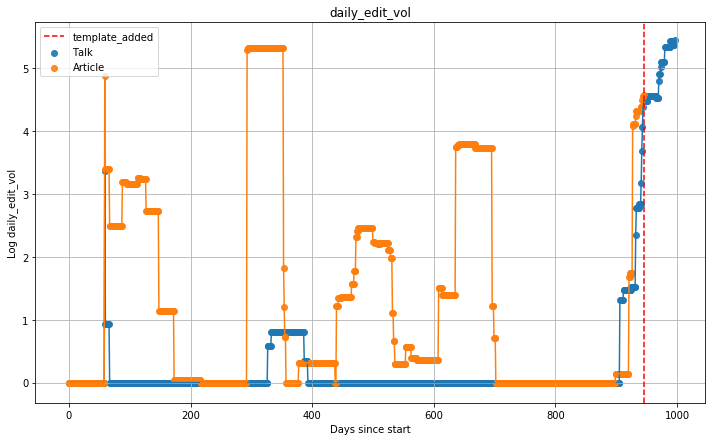

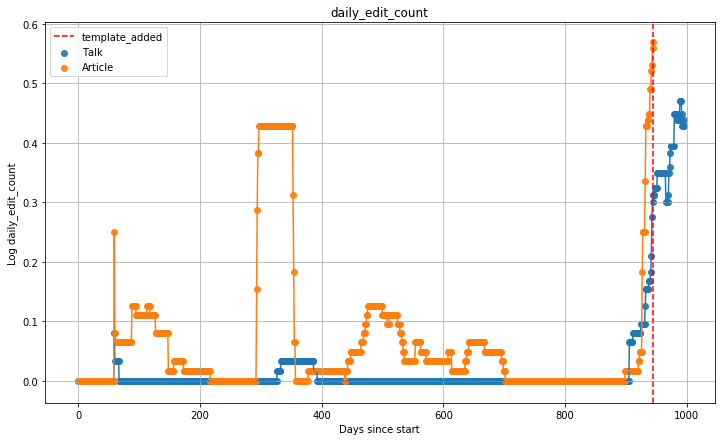

Amanda_Eliasch


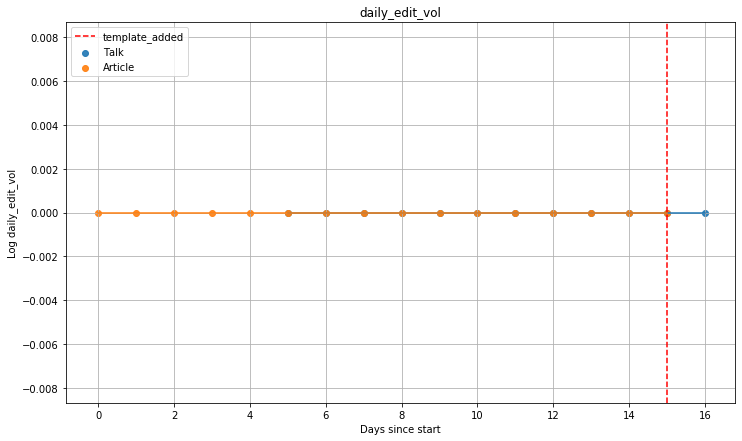

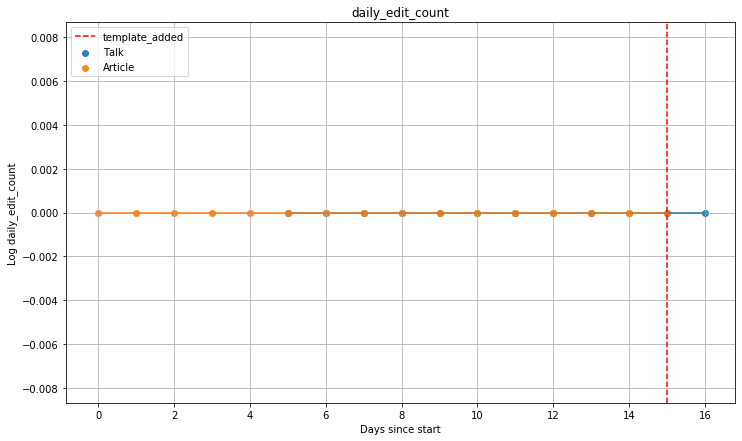

Anthony_Hudson_(football_manager)


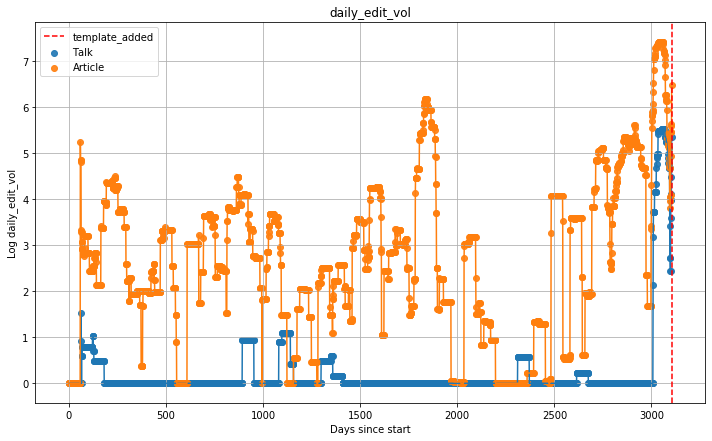

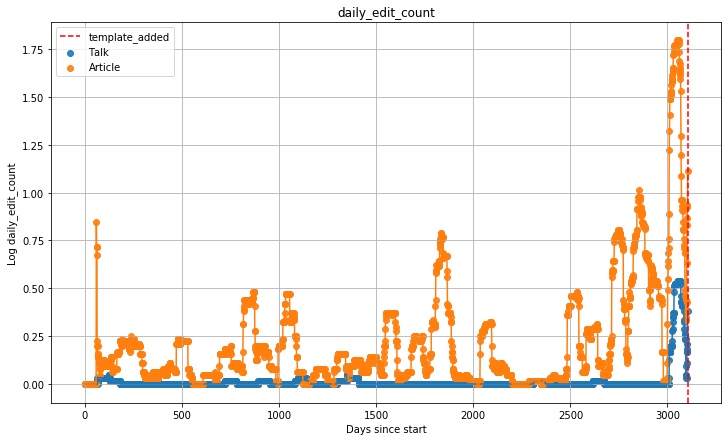

Detlef_Soost


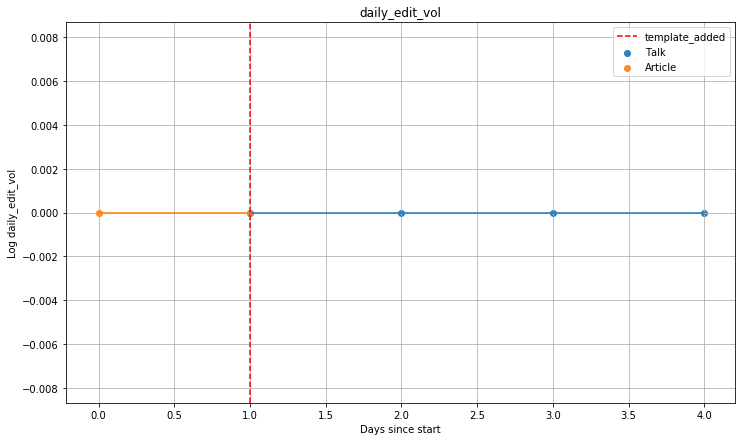

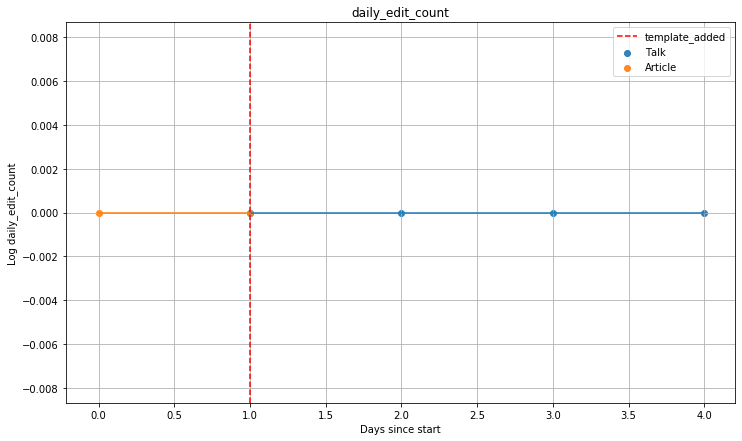

H._Raja


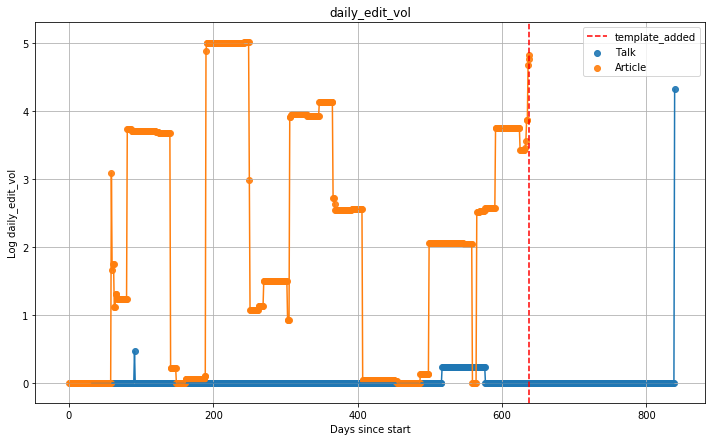

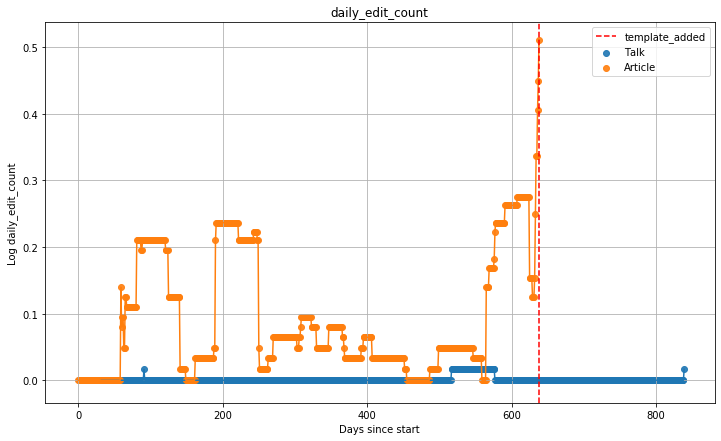

J._Scott_Armstrong


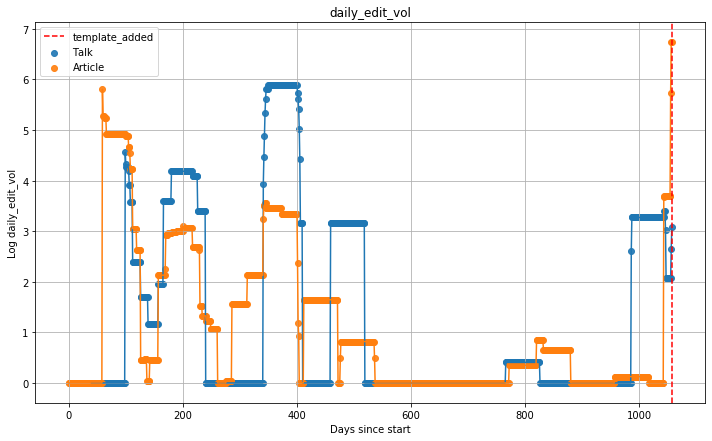

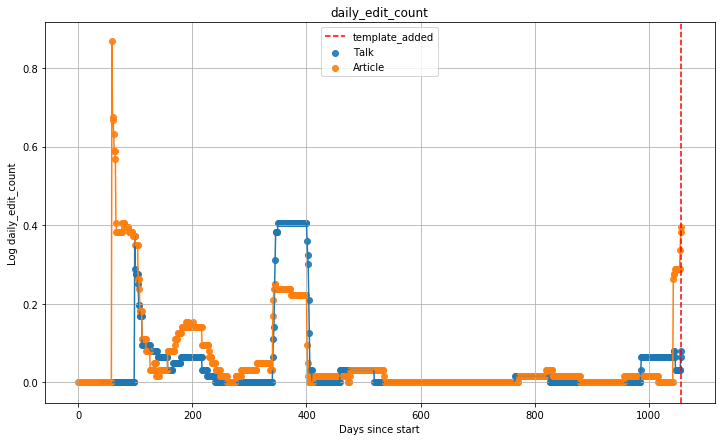

JJ_Rendón


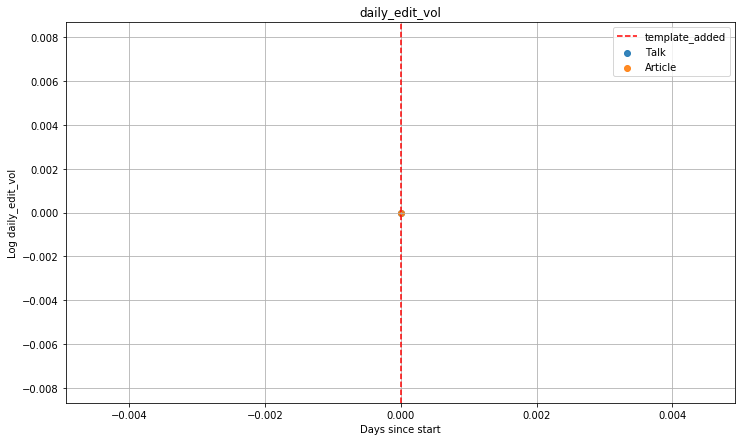

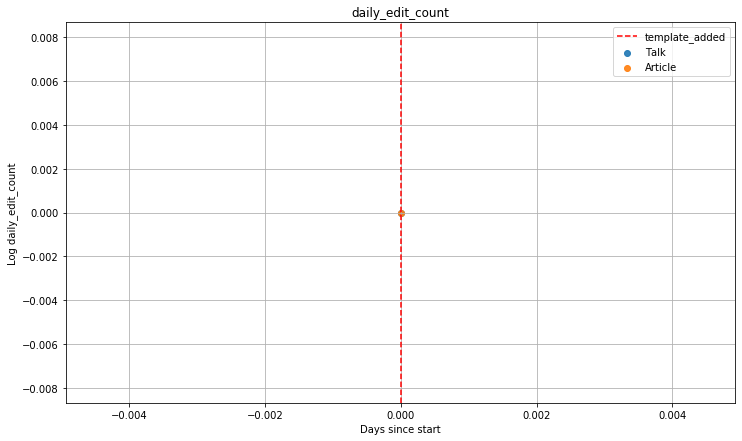

Jamie_Kaler


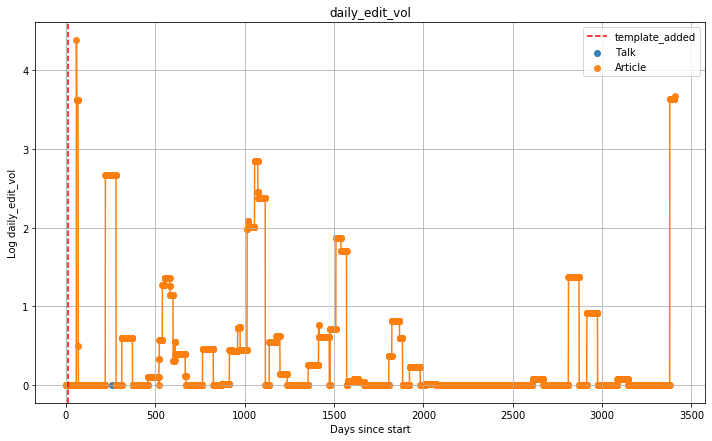

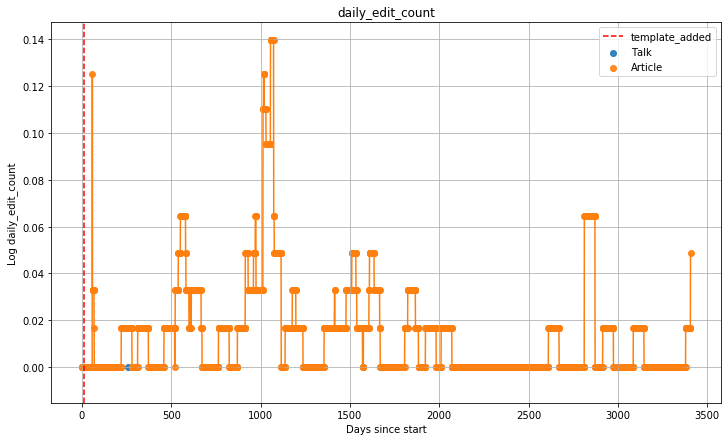

Joe_Arpaio


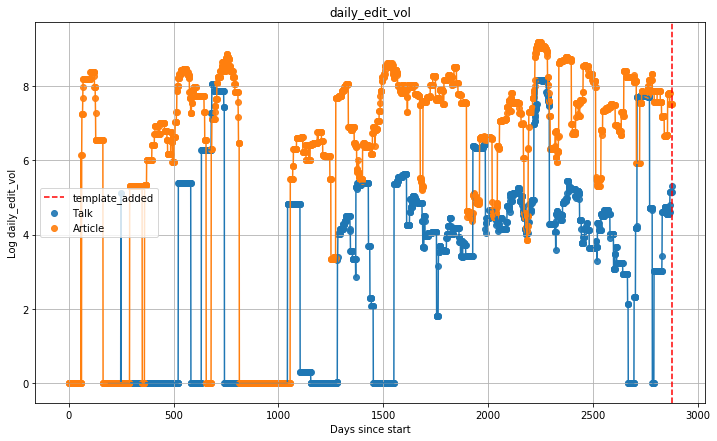

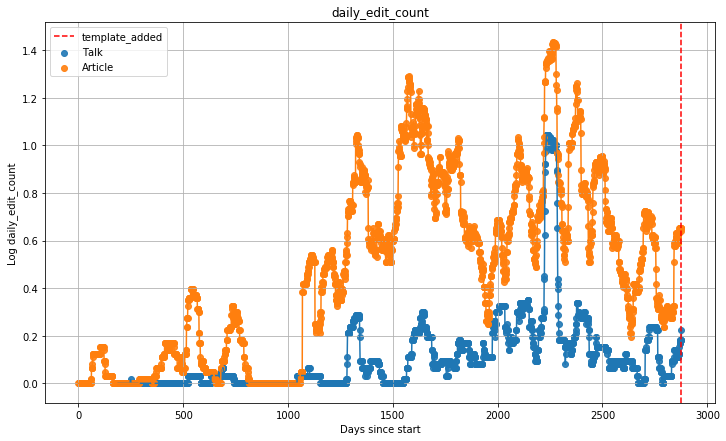

Joe_Bock_(American_football)


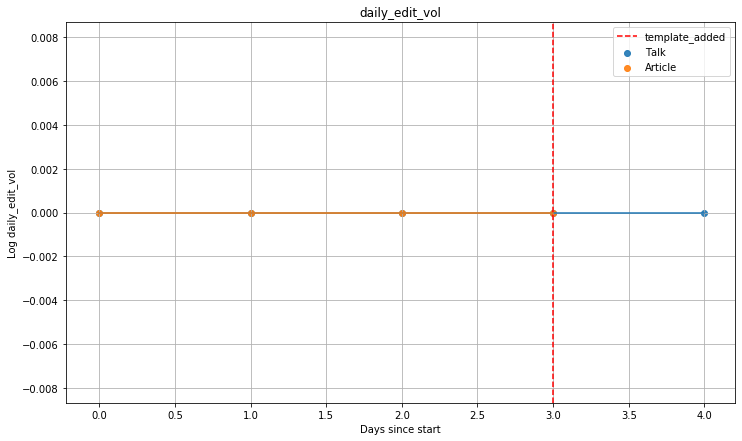

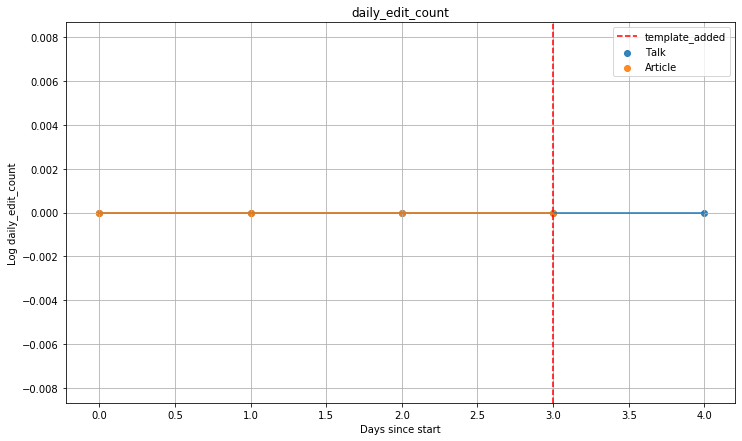

Michael_J._Jacobs


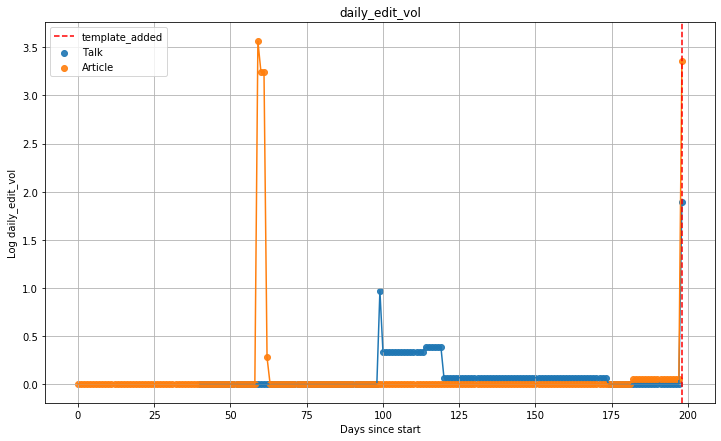

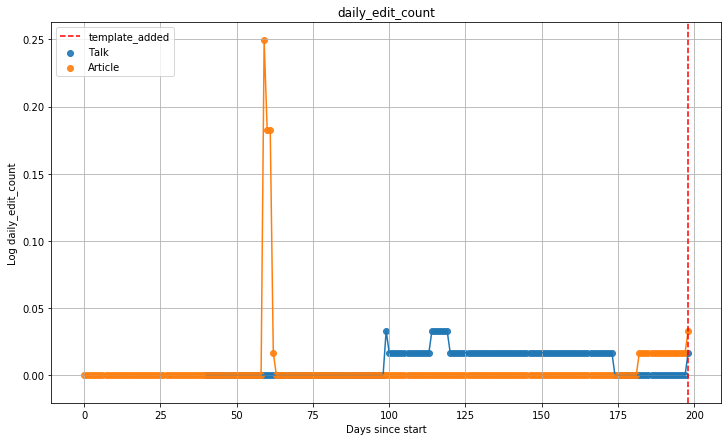

Scott_Rasmussen


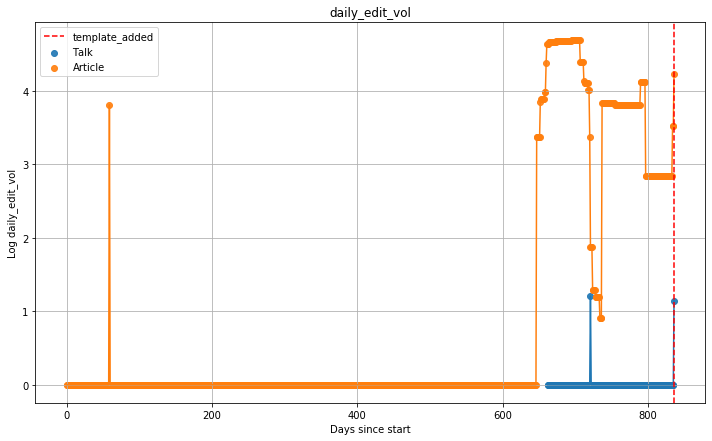

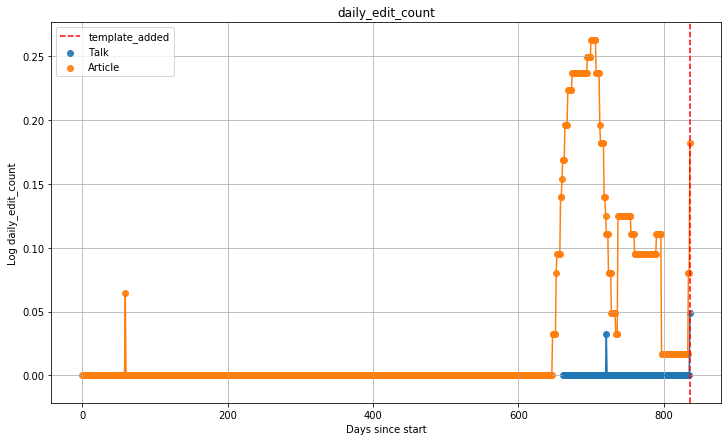

Varo_Venturi


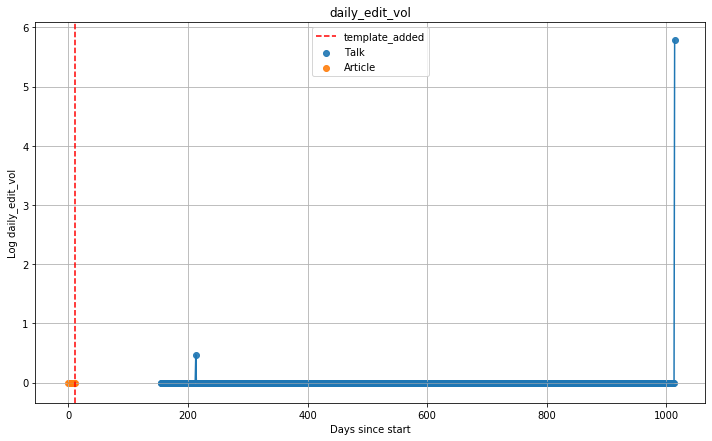

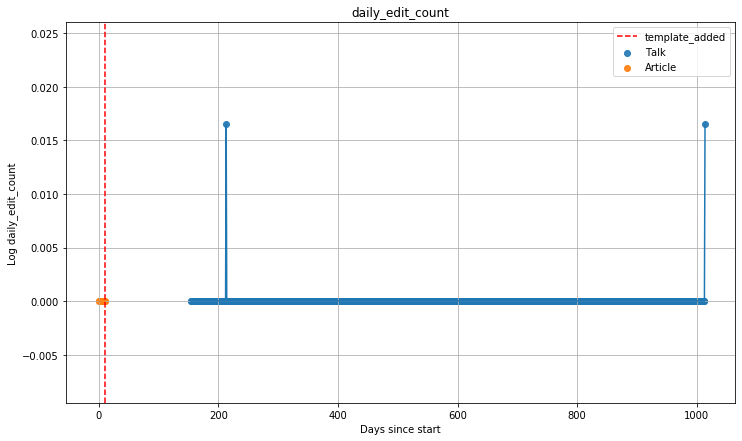

In [224]:
talk_grouped = talk_page_revisions.groupby('page_title')
article_grouped = article_revisions.groupby('page_title')

for page in ratios.index.values:
    print(page)
    fig = plot_daily_activity(talk_grouped.get_group(page),
                              article_grouped.get_group(page),
                          'daily_edit_vol',60)

    fig = plot_daily_activity(talk_grouped.get_group(page),
                              article_grouped.get_group(page),
                              'daily_edit_count',60)